## Mesoscopic simulation of HCMV

Use this notebook to download and processes the trajectory of the mesoscopic simulation of a human cytomegalovirus. 

Codes are provided to measure the radial discribution of different species present in the simulation.

In [9]:
import glob
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm

In [2]:
working_dir = "./trajectory"

simulation_id = "23_03_2023"

data_file_name = f"{working_dir}/cytomegalovirus_{simulation_id}.npz"

### Downloading trajectory + data file

the next cell will check if the data file is already present in the working directory. If not, it will be automatically downloaded.

In [10]:
if not glob.glob(data_file_name):
    
    print("Downloading simulation trajectory...")

    urllib.request.urlretrieve(r"https://ftp.mi.fu-berlin.de/pub/cmb-data/hcmv_trajectories/cytomegalovirus_23_03_2023.npz",
                       data_file_name)

In [11]:
data_frame = np.load(data_file_name, allow_pickle=True)

In [12]:
for field_name in data_frame.keys():
    globals()[field_name] = data_frame[field_name]

In [13]:
print(particle_positions.shape)
named_types = np.array(named_types)[()]

(300, 48667, 3)


In [14]:
all_types = np.sort([_key for _key in named_types.keys()])

### Particle types in the simulation

In [15]:
for _type in all_types:
    print(f"particles with type {_type} are of species {named_types[_type]}")

particles with type 1 are of species MEMBRANE_1
particles with type 2 are of species MEMBRANE_2
particles with type 3 are of species Capsid
particles with type 4 are of species Capsid_outer
particles with type 5 are of species gB_postfusion_TM
particles with type 6 are of species gB_postfusion
particles with type 7 are of species gB_prefusion_TM
particles with type 8 are of species gB_prefusion
particles with type 9 are of species gHgLgO_TM
particles with type 10 are of species gHgLgO
particles with type 11 are of species UL132_TM
particles with type 12 are of species UL132
particles with type 13 are of species gM_TM
particles with type 14 are of species gM
particles with type 15 are of species UL41A_TM
particles with type 16 are of species UL41A
particles with type 17 are of species RL10_TM
particles with type 18 are of species RL10
particles with type 19 are of species UL33_TM
particles with type 20 are of species UL33
particles with type 21 are of species UL119_TM
particles with typ

### Visualizing the virion

Text(0.5, 0, 'Z')

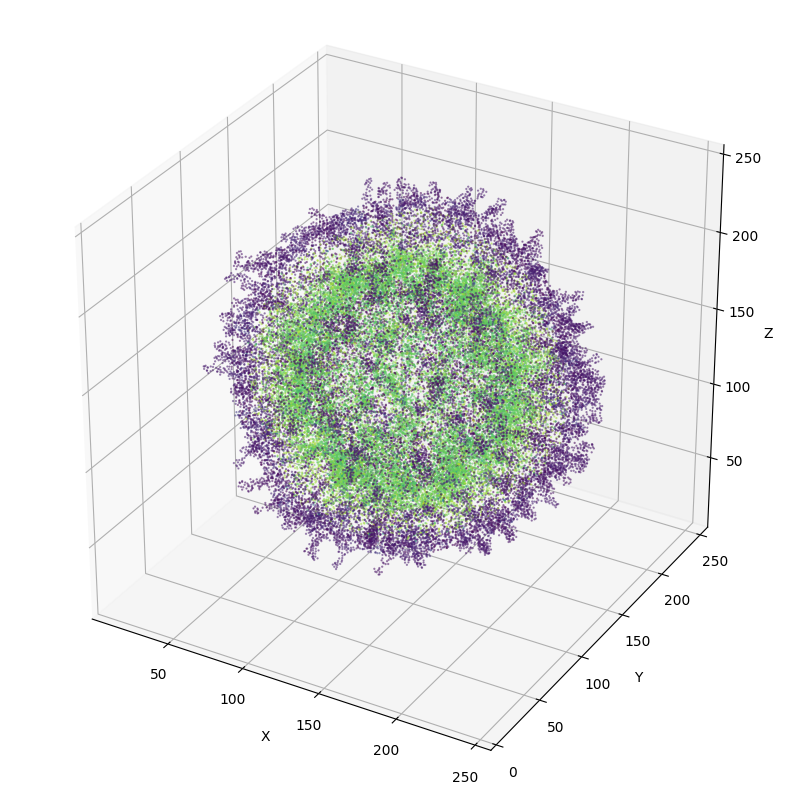

In [16]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

ax.scatter(particle_positions[-1, :, 0],
           particle_positions[-1, :, 1],
           particle_positions[-1, :, 2], s=0.4, c=particle_types[-1, :], alpha=0.5)

ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

### Radial distribution

The following cells contain the code for sampling the radial position of different particles from simulation trajectories and estimating mean and standard deviation of radial positions, as well as the radial probability density of finding a particle of a specific type in $\left[r, r + dr\right]$

In [17]:
n_sampling_steps = 50

max_step = len(particle_positions)
relax_step = max(max_step - n_sampling_steps, 0)

print(f"sampling radial distribution in step range {relax_step}, {max_step}")

n_div = 200
r_max = 125.0

sampling radial distribution in step range 250, 300


In [18]:
radial_dist = {}

bins = np.linspace(0.0, r_max, n_div + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
dr = bins[1] - bins[0]

fac = 1.0 / (4.0 * np.pi * bin_centers ** 2 * dr)

for __t in all_types:

    _type_name = named_types[__t]
    
    radial_dist[_type_name] = {'mean':np.empty(0), 'std': np.empty(0), 'pdf': np.zeros(n_div)}

n_frames = 0.0

for _pos, _type, _bdim in tqdm(zip(particle_positions[relax_step:max_step],
                                   particle_types[relax_step:max_step],
                                   box_dimensions[relax_step:max_step]), total=max_step - relax_step):
    
    n_frames += 1.0
    
    radial_dist_sample = []
    
    for __t in range(np.amax(all_types) + 1):

        radial_dist_sample.append([])

    for __p, __t in zip(_pos, _type):

        radial_dist_sample[__t].append(np.sqrt(np.sum((__p - 0.5 * _bdim) ** 2)))
    
    for __t in all_types:
        
        _type_name = named_types[__t]
        
        radial_dist[_type_name]['mean'] = np.append(radial_dist[_type_name]['mean'],
                                                    np.mean(radial_dist_sample[__t]))
        
        radial_dist[_type_name]['std'] = np.append(radial_dist[_type_name]['std'],
                                                   np.std(radial_dist_sample[__t]))
        
        n_particles = len(radial_dist_sample[__t])
        
        hist, bin_edges = np.histogram(radial_dist_sample[__t], bins=bins)
                
        radial_dist[_type_name]['pdf'] += hist * fac / float(n_particles)
        
for __t in all_types:

    _type_name = named_types[__t]
    
    radial_dist[_type_name]['pdf'] = radial_dist[_type_name]['pdf'] / n_frames

radial_dist["shared"] = {'time': simulation_time[relax_step:max_step], 'bins': bins[:-1]}

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0, 0.5, 'Radial position (mean $\\pm \\frac{1}{2}$ std) [nm]')

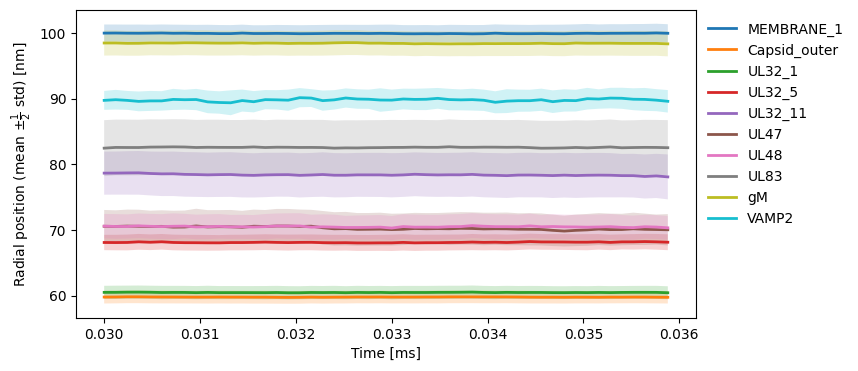

In [19]:
plt.figure(figsize=(8, 4))

for _name in ["MEMBRANE_1", "Capsid_outer", "UL32_1", "UL32_5", "UL32_11", "UL47", "UL48", "UL83", "gM", "VAMP2"]:
    
    plt.plot(radial_dist['shared']['time'], radial_dist[_name]['mean'], label=_name, lw = 2)
    plt.fill_between(radial_dist['shared']['time'],
                     radial_dist[_name]['mean'] - 0.5 * radial_dist[_name]['std'],
                     radial_dist[_name]['mean'] + 0.5 * radial_dist[_name]['std'], lw = 0, alpha=0.2)

plt.legend(frameon=False, bbox_to_anchor=(1.0, 1.0))

plt.xlabel("Time [ms]")
plt.ylabel(r"Radial position (mean $\pm \frac{1}{2}$ std) [nm]")

Text(0, 0.5, 'Probability density [1/nm$^3$]')

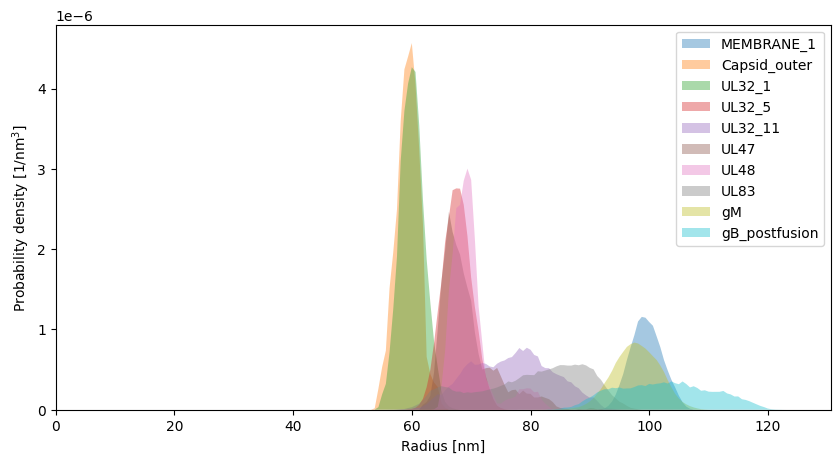

In [21]:
plt.figure(figsize=(10, 5))


for _name in ["MEMBRANE_1", "Capsid_outer", "UL32_1", "UL32_5", "UL32_11", "UL47", "UL48", "UL83", "gM", "gB_postfusion"]:
    
    plt.fill_between(radial_dist['shared']['bins'], 0.0, radial_dist[_name]['pdf'], label=_name, lw=2, alpha=0.4)

plt.legend()

plt.ylim(0.0, None)
plt.xlim(0.0, None)

plt.xlabel('Radius [nm]')
plt.ylabel('Probability density [1/nm$^3$]')

In [22]:
with open(f'{working_dir}/radial_distribution_of_particles_{simulation_id}.pkl', 'wb') as file:
    pickle.dump(radial_dist, file, protocol=pickle.HIGHEST_PROTOCOL)